In [1]:
import sys
import time
import gensim
import re
import nltk
import os
import gzip

import pandas as pd
import numpy as np

from PIL import Image
from gensim.models import word2vec

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D


import datafold.pcfold as pfold
from datafold.dynfold import DiffusionMaps
from datafold.utils.plot import plot_pairwise_eigenvector

from utils.utils import Loaders, Plotters

In [2]:
# Load google word2vec data
%matplotlib inline
pd.options.mode.chained_assignment = None 
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [3]:
# Load MNIST fashion data
X_train, y_train = Loaders.load_mnist('data/fashion', kind='train')
X_test, y_test = Loaders.load_mnist('data/fashion', kind='t10k')
X_train = X_train/255.0
X_test = X_test/255.0

In [4]:
# Load  generated vadere data
df = pd.read_csv('postviz_.csv')
ids = pd.read_csv('out_.csv')
X_data = []
Y_data = []
for pd_id, src in ids.iterrows():
    X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy() * 2).astype(int)
    Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy() * 2).astype(int)
    q = np.zeros((40,40))
    q[X,Y] = 1
    X_data.append(q.flatten())
    Y_data.append(src["sourceId-PID5"])

In [38]:
number_of_elements_train = 1000

X_pcm = pfold.PCManifold(X_train[0:number_of_elements_train])
X_pcm.optimize_parameters(result_scaling=3)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

t0 = time.time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap_ = dmap.fit(X_pcm)


epsilon=69.21094939375291, cut-off=35.705921116366206


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

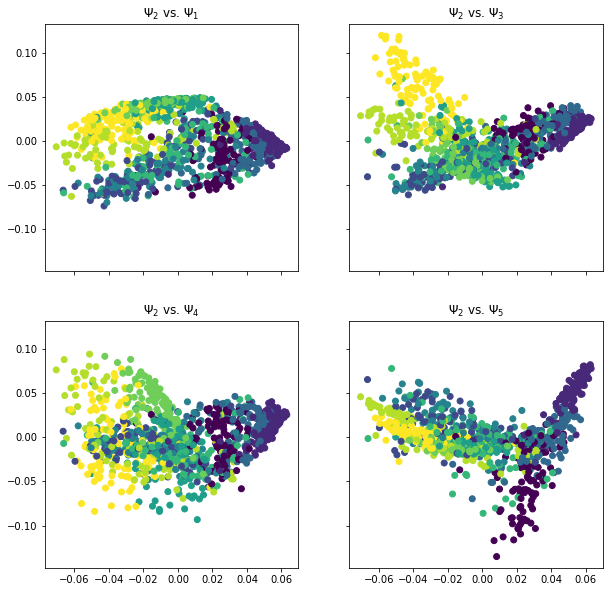

In [11]:
plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[:, 1:],
                          n=1,
                          idx_start=1,
                          fig_params=dict(figsize=(10,10)),
                          scatter_params=dict(c=y_train[0:number_of_elements_train]))




In [12]:
dmap = dmap_.set_coords([2, 3])
X_dmap_train = dmap.transform(X_pcm)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

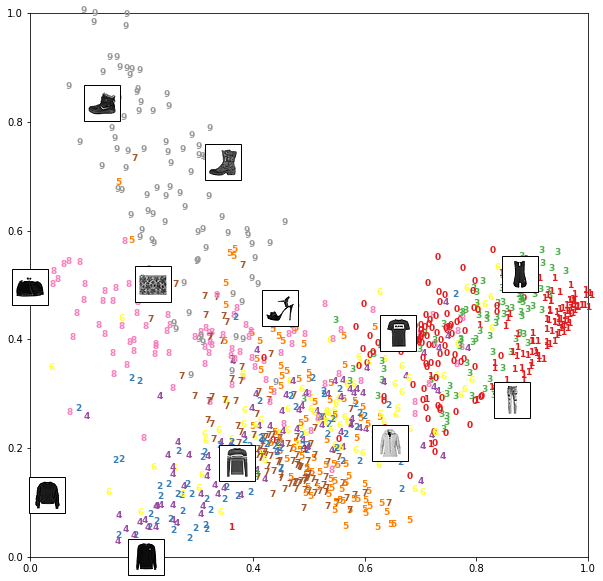

In [13]:
Plotters.plot_embedding_fashion_mnist(X_dmap_train, y_train, X_train)

In [ ]:

dmap = dmap_.set_coords([1, 2, 3])
X_dmap_train = dmap.transform(X_pcm)


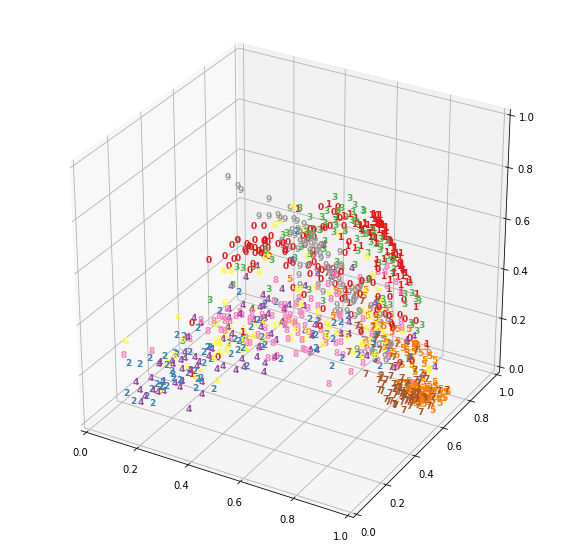

In [43]:
%matplotlib inline
X =   X_dmap_train
y = y_train
title=None
#Plotters.plot_embedding_fashion_mnist_3d(X_dmap_train, y_train, X_train)
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)
"""Scale and visualize the embedding vectors"""
plt.figure(figsize=[10, 10])
ax = plt.subplot(111, projection='3d')
for i in range(X.shape[0]):
    ax.text(
        X[i, 0],
        X[i, 1],
        X[i, 2],
        str(y[i]),
        color=plt.cm.Set1(y[i] / 10.0),
        fontdict={"weight": "bold", "size": 9},
    )

if title is not None:
    plt.title(title)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IndexError: index 2 is out of bounds for axis 1 with size 2

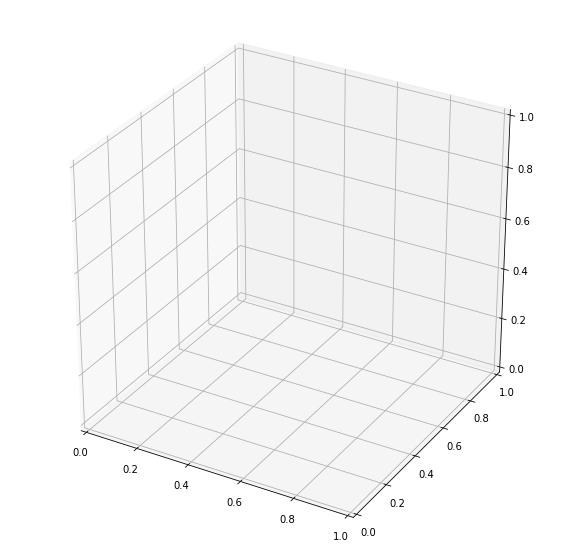

In [15]:
number_of_elements_test = 2000
X_dmap_test = dmap.transform(X_test[0:number_of_elements_test])
Plotters.plot_embedding_fashion_mnist_3d(X_dmap_test, y_test, X_test)

In [ ]:
n_of_words = 2000
X = model.vectors[0:n_of_words]

X_pcm = pfold.PCManifold(X)
X_pcm.optimize_parameters(result_scaling=2)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

t0 = time.time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)
dmap = dmap.set_coords([1, 2])
X_dmap = dmap.transform(X_pcm)

print(f"Diffusion map embedding of the words (time {(time.time() - t0)})")


In [ ]:
Plotters.plot_embeddings_for_datafold(X_dmap, model, number_of_points=100)

In [ ]:
Plotters.tsne_plot(model, number_of_words=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

     pedestrianId  sourceId-PID5
233           234              3


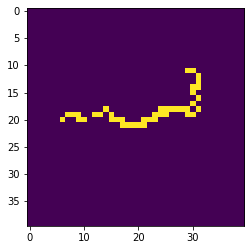

In [27]:
pd_id = 234
X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy() * 2).astype(int)
Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy() * 2).astype(int)
q = np.zeros((40,40))
q[X,Y] += 1
plt.imshow(q, interpolation='nearest')
plt.show()
print(ids[ids.pedestrianId == pd_id])

In [28]:
X_pcm = pfold.PCManifold(X_data)
X_pcm.optimize_parameters(result_scaling=3)

print(f'epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}')

t0 = time.time()
dmap = DiffusionMaps(kernel=pfold.GaussianKernel(epsilon=X_pcm.kernel.epsilon),
                     n_eigenpairs=6, dist_kwargs=dict(cut_off=X_pcm.cut_off))

dmap = dmap.fit(X_pcm)


epsilon=50.81245438268045, cut-off=30.594117081556707


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

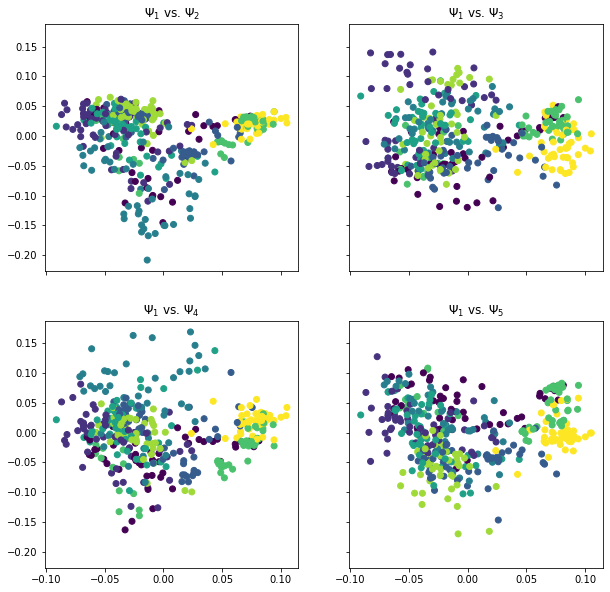

In [29]:
plot_pairwise_eigenvector(eigenvectors=dmap.eigenvectors_[:, 1:],
                          n=0,
                          idx_start=1,
                          fig_params=dict(figsize=(10,10)),
                          scatter_params=dict(c=Y_data))

dmap = dmap.set_coords([1, 2])
X_dmap_pid = dmap.transform(X_pcm)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

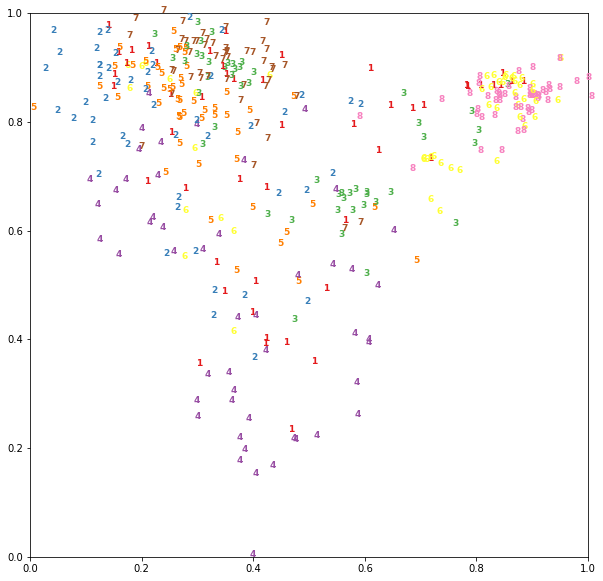

In [30]:
Plotters.plot_embedding_pids(X_dmap_pid, Y_data)

In [31]:
df[df.pedestrianId == 1]["x-PID1"]
q = np.zeros((80,80))
q[ df[df.pedestrianId == pd_id]["x-PID1"], df[df.pedestrianId == pd_id]["y-PID1"] ] = 1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

   pedestrianId  sourceId-PID5
0             1              1


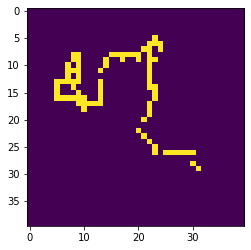

In [32]:
pd_id = 1
X = (df[df.pedestrianId == pd_id]["x-PID1"].to_numpy() * 2).astype(int)
Y = (df[df.pedestrianId == pd_id]["y-PID1"].to_numpy() * 2).astype(int)
q = np.zeros((40,40))
q[X,Y] += 1
plt.imshow(q, interpolation='nearest')
plt.show()
print(ids[ids.pedestrianId == pd_id])